#### Benchmaking Experiment 004
- Model : Model4
- Dataset : PAMAP2
- Semantic Space : Glove50
- Cross Validation : 5-fold fixed classes
- Feature Loss : MSELoss

In [1]:
import os 
from datetime import date
from tqdm import tqdm
from copy import deepcopy
import numpy as np 
import pandas as pd

import torch 
from torch import nn, Tensor
from torch.nn import functional as F
from torch.nn.modules import MultiheadAttention, Linear, Dropout, BatchNorm1d, TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.nn import MSELoss

from src.datasets.data import PAMAP2Reader
from src.datasets.dataset import PAMAP2Dataset
from src.datasets.utils import load_attribute

from src.models.ts_transformer import *
from src.models.loss import FeatureLoss, AttributeLoss 

from src.utils.analysis import action_evaluator
from src.running import train_step, eval_step

In [16]:
# setup model configurations
config = {
    # general information
    "experiment-name": "test-001", 
    "datetime": date.today(),
    "device": "gpu",
    "dataset": "PAMAP2",
    "Model": "RelativeGlobalAttention",
    "sem-space": "attr",
    # model training configs
    "include_attribute_loss": True, 
    "semantic_size": 64,
    "n_actions": 18,
    "folding": True,
    "fold_classes": [['watching TV', 'house cleaning', 'standing', 'ascending stairs'], ['walking', 'rope jumping', 'sitting', 'descending stairs'], ['playing soccer', 'lying', 'vacuum cleaning', 'computer work'], ['cycling', 'running', 'Nordic walking'], ['ironing', 'car driving', 'folding laundry']],
    "lr": 0.001,
    "n_epochs": 10,
    "optimizer": "adam",
    "batch_size": 32,
    "semantic_loss": "cosine_distance",
    # model configs
    "d_model": 128, 
    "num_heads": 2,
    "dim_feedforward": 128,
    "num_layers": 2,
    "pos_encoding": 'fixed',
    "activation": 'relu',
    "norm": "BatchNorm",
    # dataset configs
    "window_size": 5, 
    "overlap": 0.5,
    "seq_len": 200,
    "seen_split": 0.2,
    "unseen_split": 0.8
}

---
Model Building

In [3]:
class Model12(nn.Module):
    def __init__(self, in_ft, d_model, num_heads, num_layers, n_classes, dim_feedforward, ft_size,
                pos_encoding='fixed', activation='gelu', norm='BatchNorm', max_len=1024, dropout=0.1, freeze=False):
        super(Model12, self).__init__()
        self.in_ft = in_ft
        self.max_len = max_len
        self.d_model = d_model
        self.num_heads = num_heads
        self.ft_size = ft_size
        self.n_classes = n_classes

        # feature prep layer
        self.DenseL = nn.Linear(in_ft, d_model)
        self.pos_enc = get_pos_encoder(pos_encoding)(d_model, dropout=dropout*(1.0 - freeze), max_len=max_len)
        # relative global attention layer
        if norm == 'LayerNorm':
            encoder_layer = TransformerEncoderLayer(d_model, self.num_heads, dim_feedforward, dropout*(1.0 - freeze), activation=activation)
        else:
            encoder_layer = TransformerBatchNormEncoderLayer(d_model, self.num_heads, dim_feedforward, dropout*(1.0 - freeze), activation=activation)

        self.AttnL = nn.TransformerEncoder(encoder_layer, num_layers)

        # positional encoding concat <-> 1DConv 
        self.Act = F.relu#_get_activation_fn(activation)
        self.AvgPoolL = nn.AvgPool2d((self.max_len,1))
        self.DenseL2 = nn.Linear(self.d_model, self.ft_size)
        self.dropout = nn.Dropout1d(dropout)
        self.logist = nn.Linear(self.ft_size, self.n_classes)

    def forward(self, x):
        x = x.permute(1,0,2)
        out = self.DenseL(x)
        out = self.pos_enc(out)* math.sqrt(self.d_model)
        out = self.AttnL(out)
        out = out.permute(1, 0, 2)
        out = self.Act(out)
        out = self.AvgPoolL(out)
        out = torch.squeeze(out)
        out = self.dropout(out)
        out1 = self.DenseL2(out)
        out = self.logist(out1)   
        return out, out1
    

---

In [4]:
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity

In [5]:
def train_step1(model, dataloader, optimizer, loss_module, device, class_names, phase='train', l2_reg=False, loss_alpha=0.7):
    model = model.train()

    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat, target_attr, padding_masks = batch
            # print(X, targets, target_feat, target_attr)
            X = X.float().to(device)
            target_feat = target_feat.float().to(device)
            target_attr = target_attr.float().to(device)
            targets = targets.long().to(device)
            padding_masks = padding_masks.to(device)  # 0s: ignore

            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                class_output, feat_output = model(X)
                class_loss = loss_module['class'](class_output, targets.squeeze())
                feat_loss = loss_module['feature'](feat_output, target_feat)

            loss = loss_alpha*class_loss+(1-loss_alpha)*feat_loss

            if phase == 'train':
                loss.backward()
                optimizer.step()

            metrics = {"loss": loss.item()}
            with torch.no_grad():
                total_samples += len(targets)
                epoch_loss += loss.item()  # add total loss of batch

            # convert feature vector into action class
            # using cosine 
            pred_class = np.argmax(class_output.cpu().detach().numpy(), axis=1)
            metrics["accuracy"] = accuracy_score(y_true=targets.cpu().detach().numpy(), y_pred=pred_class)
            tepoch.set_postfix(metrics)
            
    epoch_loss = epoch_loss / total_samples  # average loss per sample for whole epoch
    return metrics

In [6]:
def eval_step1(model, dataloader, loss_module, device, class_names, target_feat_met, phase='seen', l2_reg=False, print_report=True, loss_alpha=0.7):
    model = model.train()

    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch
    per_batch = {'target_masks': [], 'targets': [], 'predictions': [], 'metrics': [], 'IDs': []}

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat, target_attr, padding_masks = batch
            X = X.float().to(device)
            target_feat = target_feat.float().to(device)
            target_attr = target_attr.float().to(device)
            targets = targets.long().to(device)
            padding_masks = padding_masks.to(device)  # 0s: ignore
            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                class_output, feat_output = model(X)
                class_loss = loss_module['class'](class_output, targets.squeeze())
                feat_loss = loss_module['feature'](feat_output, target_feat)

            loss = loss_alpha*class_loss+(1-loss_alpha)*feat_loss

            # convert feature vector into action class
            # using cosine 
            if phase == 'seen':
                pred_action = np.argmax(class_output.cpu().detach().numpy(), axis=1)
            else:
                feat_numpy = feat_output.cpu().detach()
                action_probs = cosine_similarity(feat_numpy, target_feat_met)
                pred_action = np.argmax(action_probs, axis=1)
                
            per_batch['targets'].append(targets.cpu().numpy())
            per_batch['predictions'].append(pred_action)
            per_batch['metrics'].append([loss.cpu().numpy()])

            tepoch.set_postfix({"loss": loss.item()})
    
    all_preds = np.concatenate(per_batch["predictions"])
    all_targets = np.concatenate(per_batch["targets"])
    metrics_dict = action_evaluator(y_pred=all_preds, y_true=all_targets[:, 0], class_names=class_names, print_report=print_report)
    return metrics_dict

---

In [7]:
if config['device'] == 'cpu':
    device = "cpu"
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
# import PAMAP2 dataset
dataReader = PAMAP2Reader('./data/PAMAP2_Dataset/Protocol/')
actionList = dataReader.idToLabel

Reading file 1 of 14
Reading file 2 of 14
Reading file 3 of 14
Reading file 4 of 14
Reading file 5 of 14
Reading file 6 of 14
Reading file 7 of 14
Reading file 8 of 14
Reading file 9 of 14
Reading file 10 of 14
Reading file 11 of 14
Reading file 12 of 14
Reading file 13 of 14
Reading file 14 of 14


g:\FYP\Codebases\HAR-ZSL-XAI\src\datasets\data.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(data), np.asarray(labels, dtype=int), np.array(collection)


In [9]:
# import PAMAP2 attributes
activity_dict, attribute_dict, attr_mat = load_attribute('./data/PAMAP2_Dataset/PAMAP2_attributes.json')
_, attr_size = attr_mat.shape

In [17]:
# Load semantic feature space 
st = config['sem-space']
if st == 'glove50-v1':
    fpath = './data/PAMAP2_Dataset/glove_features.npy'
elif st == 'glove50-v2':
    fpath = './data/PAMAP2_Dataset/glove_featureV2.npy'
elif st == 'video-V1':
    fpath = './data/PAMAP2_Dataset/video_pca_ft.npy'
elif st == 'word2vec-v1':
    fpath = './data/PAMAP2_Dataset/word2vec_features.npy'
elif st == 'word2vec-v2':
    fpath = './data/PAMAP2_Dataset/word2vec_featureV2.npy'
elif st == 'attr':
    fpath = './data/PAMAP2_Dataset/attribute_ft.npy'

feat_mat = np.load(fpath)
n_actions, feat_size = feat_mat.shape

In [11]:
# run 5-fold running
fold_classes = config['fold_classes']
fold_cls_ids = [[actionList.index(i) for i in j] for j in fold_classes]

================ Fold-0 ================
Unseen Classes : ['watching TV', 'house cleaning', 'standing', 'ascending stairs']


seen: 100%|██████████| 131/131 [00:01<00:00, 66.79batch/s, loss=0.322]


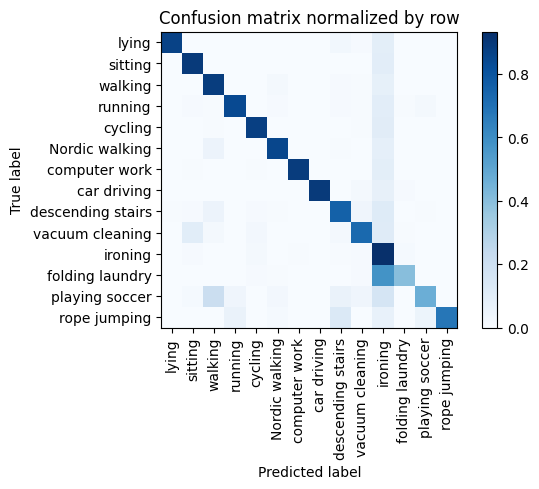

Training Epoch:  10%|█         | 1/10 [00:17<02:33, 17.10s/it]

Overall accuracy: 0.828



seen: 100%|██████████| 131/131 [00:02<00:00, 65.45batch/s, loss=0.439]


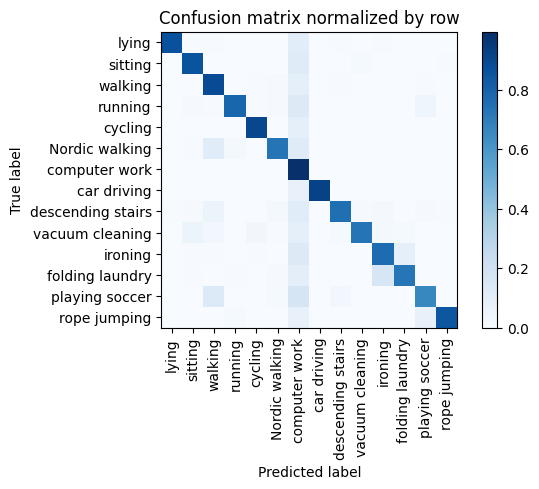

Training Epoch:  20%|██        | 2/10 [00:32<02:10, 16.33s/it]

Overall accuracy: 0.837



seen: 100%|██████████| 131/131 [00:01<00:00, 66.58batch/s, loss=0.307]


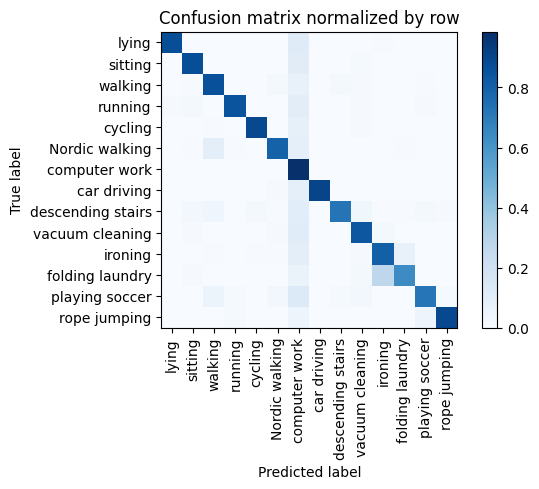

Training Epoch:  30%|███       | 3/10 [00:48<01:53, 16.16s/it]

Overall accuracy: 0.851



seen: 100%|██████████| 131/131 [00:02<00:00, 65.34batch/s, loss=0.207]


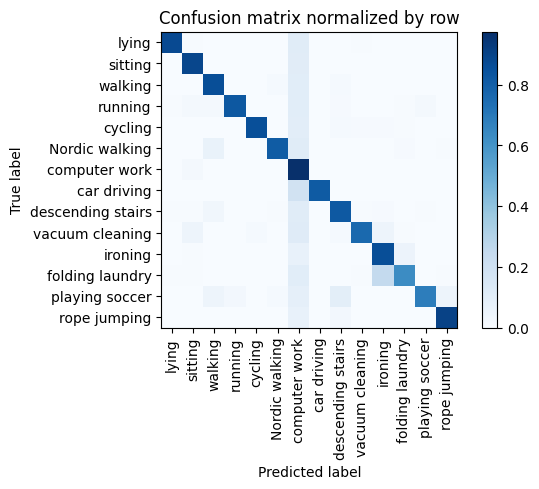

Training Epoch:  40%|████      | 4/10 [01:04<01:36, 16.12s/it]

Overall accuracy: 0.849



seen: 100%|██████████| 131/131 [00:02<00:00, 64.13batch/s, loss=0.607]


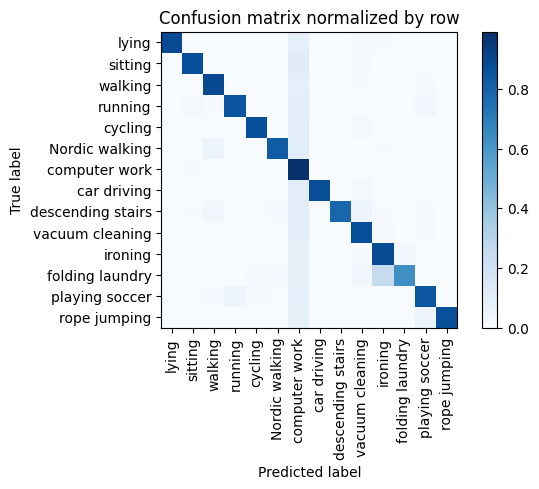

Training Epoch:  50%|█████     | 5/10 [01:21<01:20, 16.20s/it]

Overall accuracy: 0.872



seen: 100%|██████████| 131/131 [00:01<00:00, 66.78batch/s, loss=0.168]


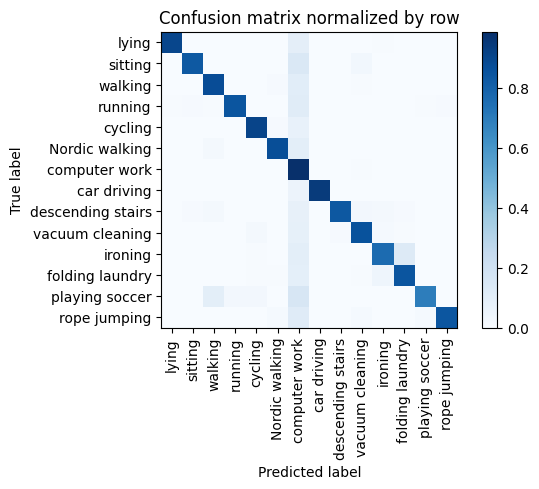

Training Epoch:  60%|██████    | 6/10 [01:37<01:04, 16.14s/it]

Overall accuracy: 0.874



seen: 100%|██████████| 131/131 [00:01<00:00, 67.60batch/s, loss=0.356]


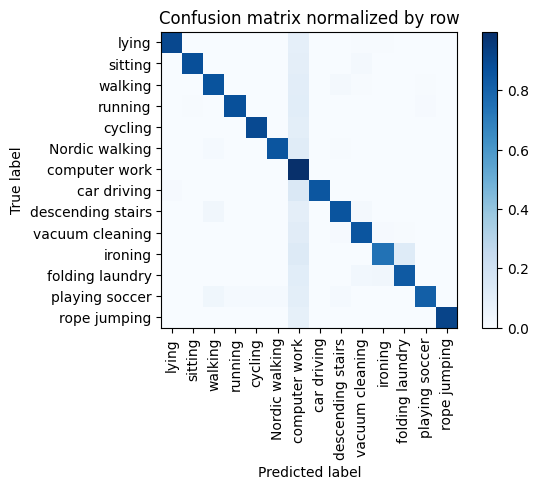

Training Epoch:  70%|███████   | 7/10 [01:53<00:48, 16.04s/it]

Overall accuracy: 0.874



seen: 100%|██████████| 131/131 [00:01<00:00, 65.99batch/s, loss=0.237]


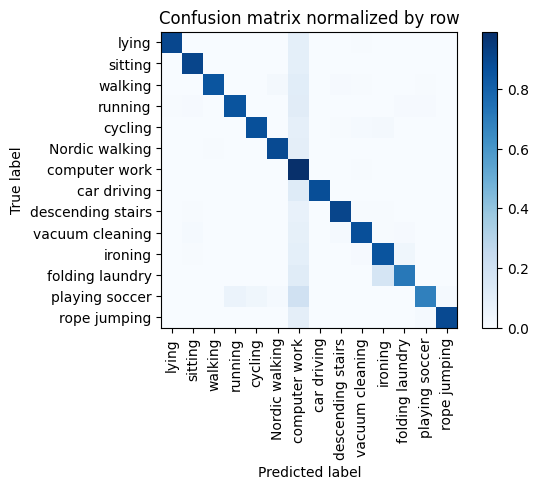

Training Epoch:  80%|████████  | 8/10 [02:09<00:32, 16.03s/it]

Overall accuracy: 0.882



seen: 100%|██████████| 131/131 [00:01<00:00, 67.26batch/s, loss=0.236]


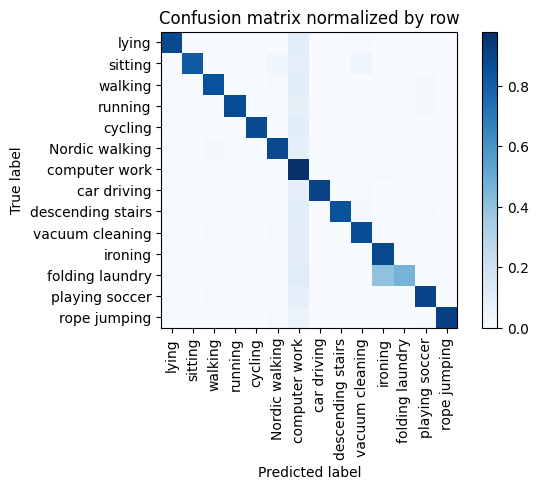

Training Epoch:  90%|█████████ | 9/10 [02:25<00:16, 16.13s/it]

Overall accuracy: 0.866



seen: 100%|██████████| 131/131 [00:01<00:00, 66.28batch/s, loss=0.307]


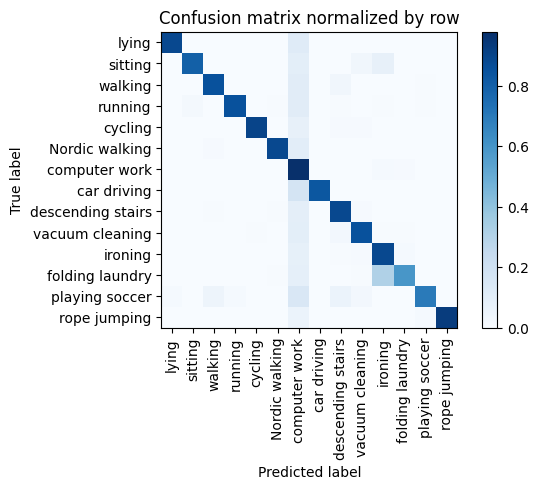

Overall accuracy: 0.866



unseen: 100%|██████████| 141/141 [00:01<00:00, 76.61batch/s, loss=4.47]


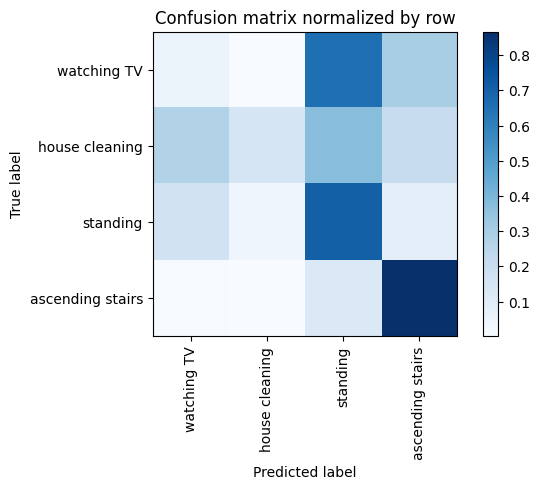

Overall accuracy: 0.456

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

        standing       0.492      0.707      0.580      0.332       1491|	 watching TV: 0.165,	ascending stairs: 0.089,	
  house cleaning       0.773      0.147      0.248      0.329       1478|	 standing: 0.372,	watching TV: 0.271,	ascending stairs: 0.210,	
ascending stairs       0.539      0.866      0.665      0.192        860|	 standing: 0.122,	watching TV: 0.007,	
     watching TV       0.044      0.046      0.045      0.147        658|	 standing: 0.657,	ascending stairs: 0.296,	

----------------------------------------------------------------------------------------------------
     avg / total       0.528      0.456      0.408        1.0       4487|	      

{'total_accuracy': 0.45620681970135946, 'precision': 0.4621012605352586, 'recall': 0.44156912683587557, 'f1': 0.3843712649235562}
================ Fold-1 ================
Unseen Classes : ['walking', 'rope jum

seen: 100%|██████████| 132/132 [00:01<00:00, 67.48batch/s, loss=1.14]


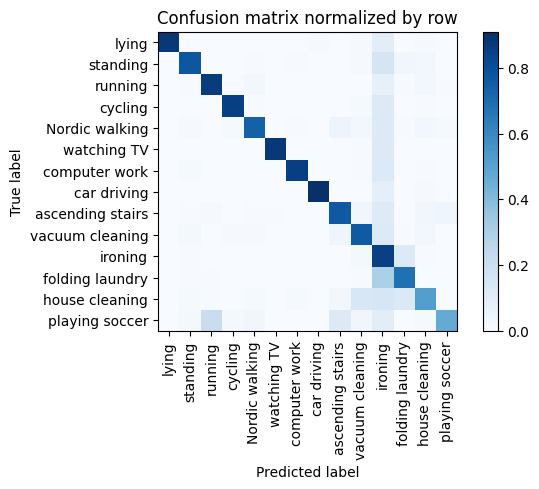

Training Epoch:  10%|█         | 1/10 [00:16<02:32, 16.96s/it]

Overall accuracy: 0.783



seen: 100%|██████████| 132/132 [00:01<00:00, 66.20batch/s, loss=1.56]


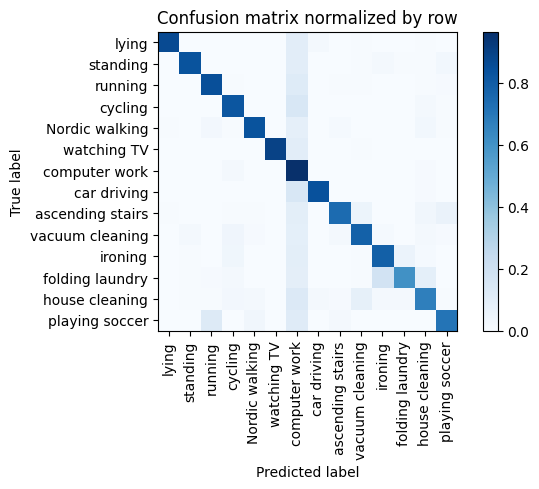

Training Epoch:  20%|██        | 2/10 [00:33<02:11, 16.48s/it]

Overall accuracy: 0.817



seen: 100%|██████████| 132/132 [00:02<00:00, 65.84batch/s, loss=0.948]


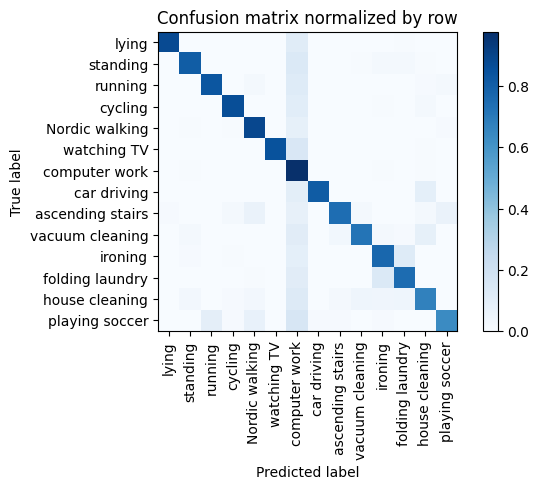

Training Epoch:  30%|███       | 3/10 [00:51<02:01, 17.32s/it]

Overall accuracy: 0.821



seen: 100%|██████████| 132/132 [00:01<00:00, 67.73batch/s, loss=1.33]


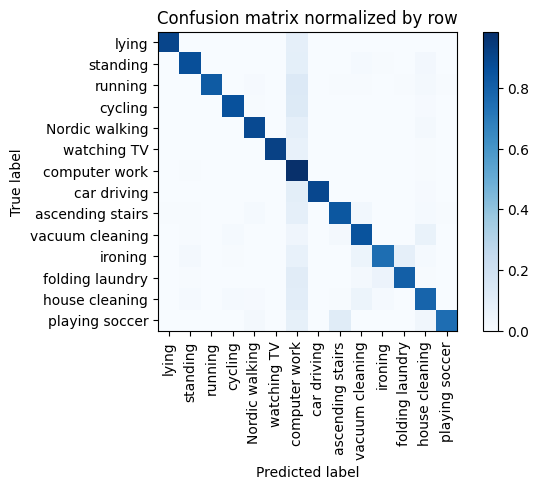

Training Epoch:  40%|████      | 4/10 [01:07<01:40, 16.81s/it]

Overall accuracy: 0.861



seen: 100%|██████████| 132/132 [00:02<00:00, 58.69batch/s, loss=0.318]


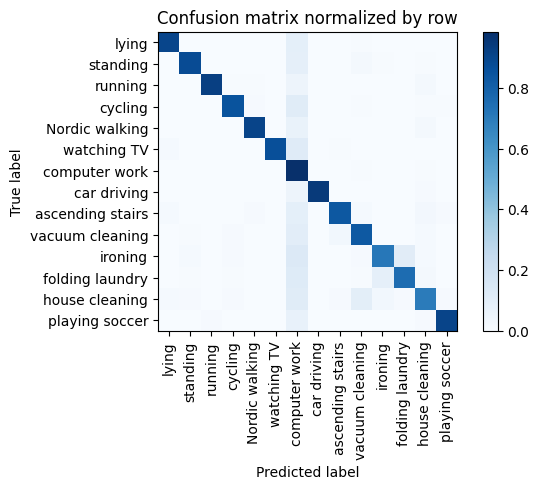

Training Epoch:  50%|█████     | 5/10 [01:23<01:23, 16.62s/it]

Overall accuracy: 0.854



seen: 100%|██████████| 132/132 [00:01<00:00, 66.36batch/s, loss=0.792]


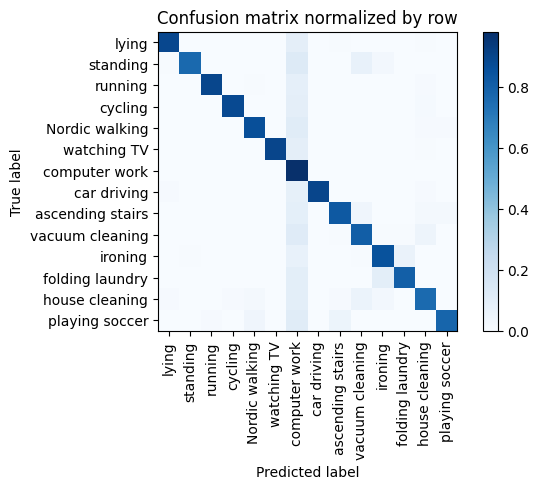

Training Epoch:  60%|██████    | 6/10 [01:40<01:06, 16.50s/it]

Overall accuracy: 0.859



seen: 100%|██████████| 132/132 [00:02<00:00, 61.38batch/s, loss=0.431]


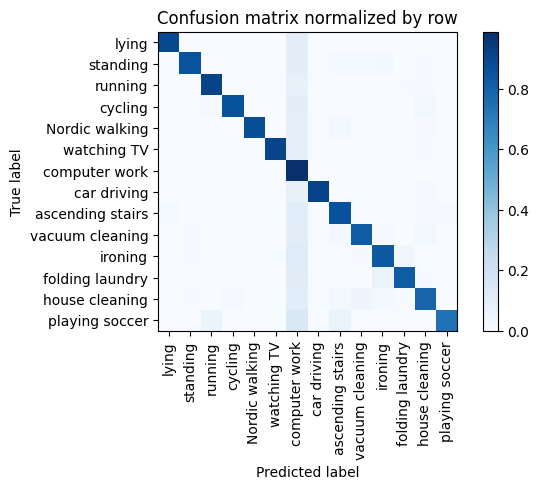

Training Epoch:  70%|███████   | 7/10 [01:56<00:49, 16.58s/it]

Overall accuracy: 0.872



seen: 100%|██████████| 132/132 [00:02<00:00, 63.35batch/s, loss=0.739]


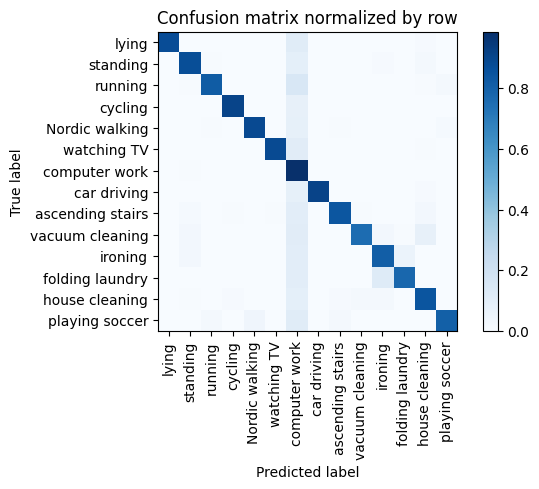

Training Epoch:  80%|████████  | 8/10 [02:14<00:34, 17.02s/it]

Overall accuracy: 0.867



seen: 100%|██████████| 132/132 [00:02<00:00, 51.37batch/s, loss=0.602]


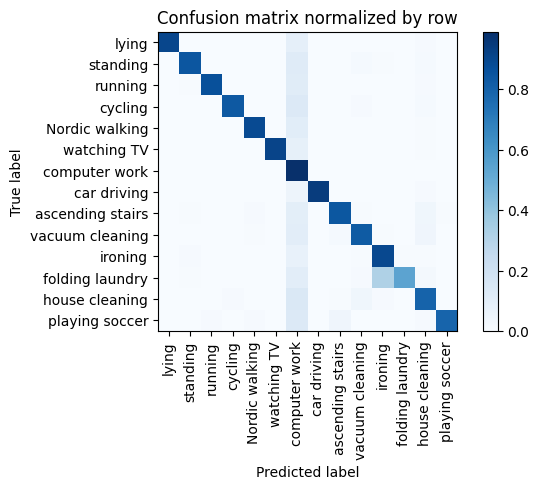

Training Epoch:  90%|█████████ | 9/10 [02:33<00:17, 17.51s/it]

Overall accuracy: 0.866



seen: 100%|██████████| 132/132 [00:02<00:00, 50.12batch/s, loss=1.38]


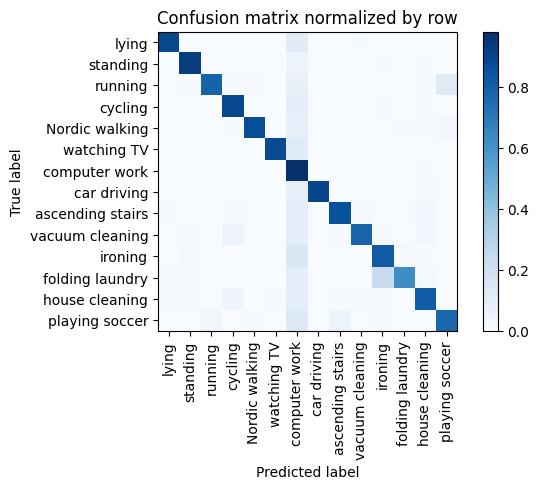

Overall accuracy: 0.859



unseen: 100%|██████████| 140/140 [00:02<00:00, 55.03batch/s, loss=5.48]


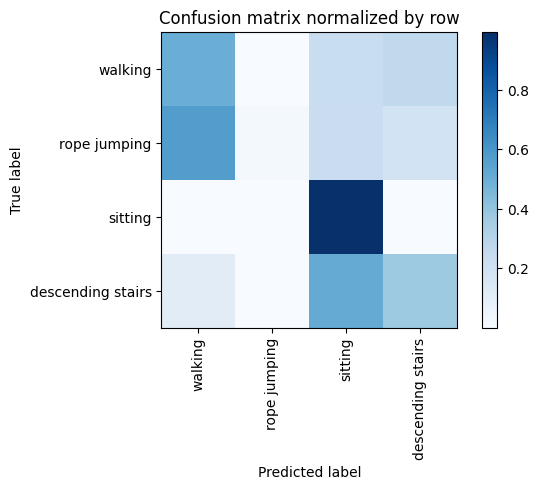

Overall accuracy: 0.598

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          walking       0.766      0.501      0.606      0.427       1903|	 descending stairs: 0.264,	sitting: 0.233,	
          sitting       0.607      0.994      0.754      0.321       1428|	 descending stairs: 0.004,	rope jumping: 0.001,	
descending stairs       0.330      0.370      0.349      0.172        764|	 sitting: 0.516,	walking: 0.113,	
     rope jumping       0.545      0.017      0.033      0.080        358|	 walking: 0.570,	sitting: 0.229,	descending stairs: 0.184,	

----------------------------------------------------------------------------------------------------
      avg / total       0.622      0.598      0.563        1.0       4453|	      

{'total_accuracy': 0.5977992364697956, 'precision': 0.5620515381367471, 'recall': 0.47059115322985556, 'f1': 0.43521097896293764}
================ Fold-2 ================
Unseen Classes : ['playing soccer', 'ly

seen: 100%|██████████| 122/122 [00:02<00:00, 48.49batch/s, loss=0.303]


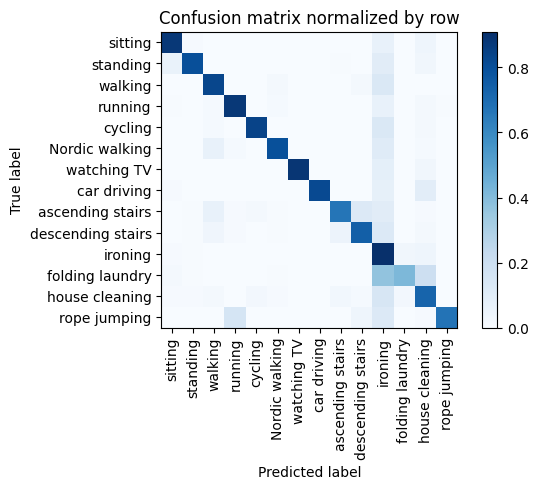

Training Epoch:  10%|█         | 1/10 [00:20<03:04, 20.49s/it]

Overall accuracy: 0.795



seen: 100%|██████████| 122/122 [00:02<00:00, 59.82batch/s, loss=0.554]


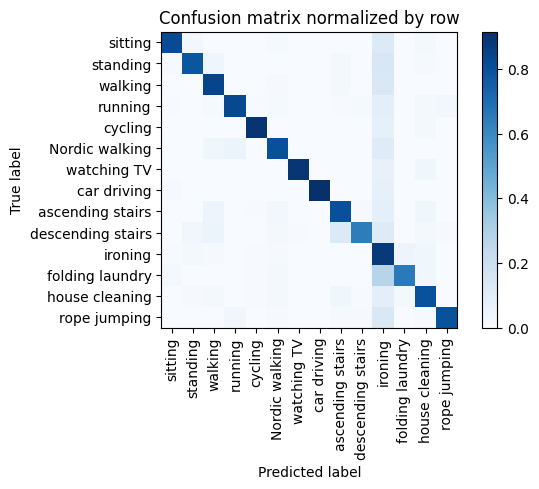

Training Epoch:  20%|██        | 2/10 [00:38<02:33, 19.18s/it]

Overall accuracy: 0.815



seen: 100%|██████████| 122/122 [00:01<00:00, 61.35batch/s, loss=0.288]


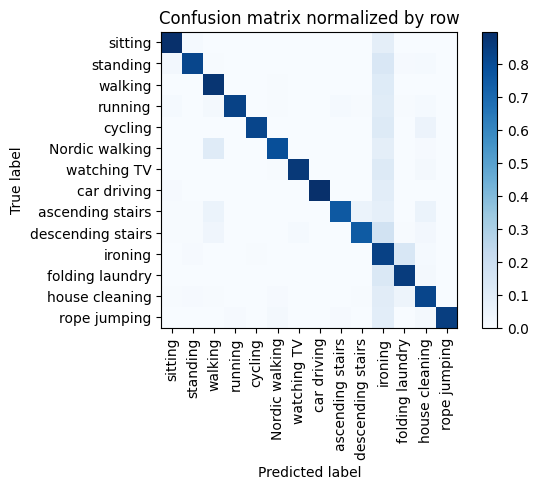

Training Epoch:  30%|███       | 3/10 [00:57<02:13, 19.04s/it]

Overall accuracy: 0.831



seen: 100%|██████████| 122/122 [00:02<00:00, 58.98batch/s, loss=0.476]


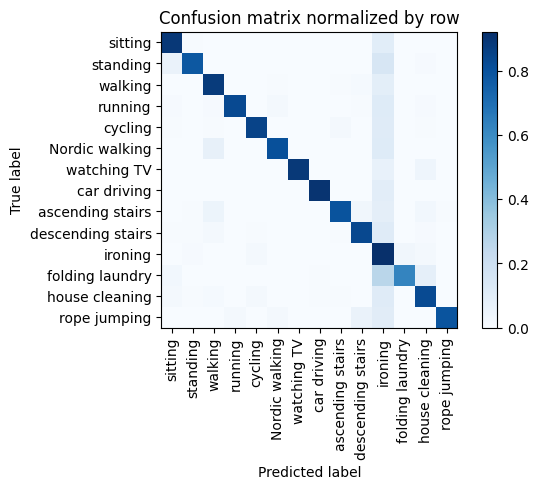

Training Epoch:  40%|████      | 4/10 [01:14<01:50, 18.34s/it]

Overall accuracy: 0.839



seen: 100%|██████████| 122/122 [00:02<00:00, 45.98batch/s, loss=0.331]


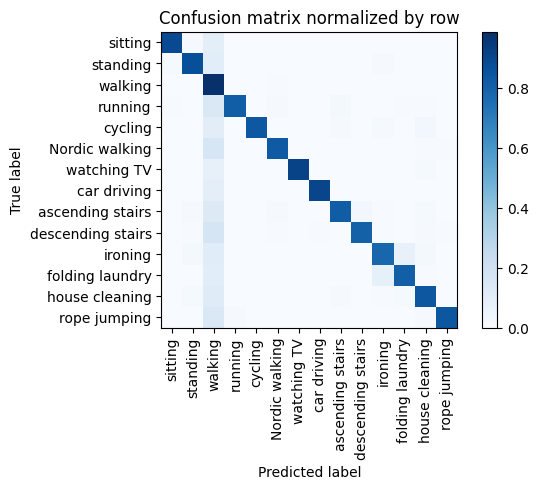

Training Epoch:  50%|█████     | 5/10 [01:32<01:29, 17.99s/it]

Overall accuracy: 0.854



seen: 100%|██████████| 122/122 [00:02<00:00, 60.12batch/s, loss=0.456]


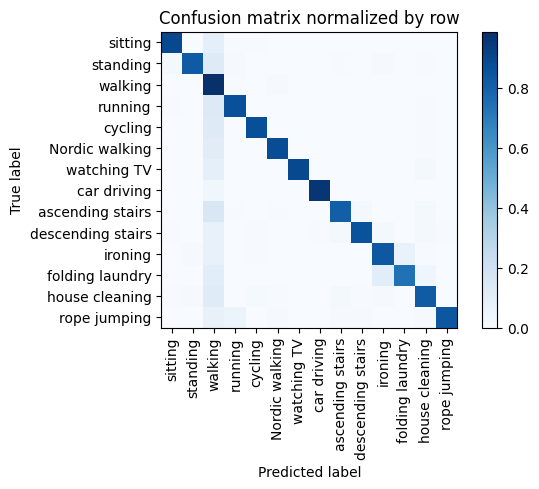

Training Epoch:  60%|██████    | 6/10 [01:48<01:09, 17.50s/it]

Overall accuracy: 0.864



seen: 100%|██████████| 122/122 [00:02<00:00, 56.27batch/s, loss=0.238]


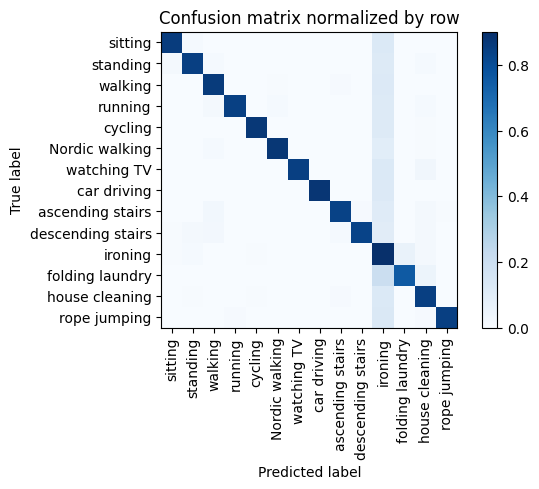

Training Epoch:  70%|███████   | 7/10 [02:07<00:53, 17.98s/it]

Overall accuracy: 0.855



seen: 100%|██████████| 122/122 [00:02<00:00, 55.87batch/s, loss=0.338]


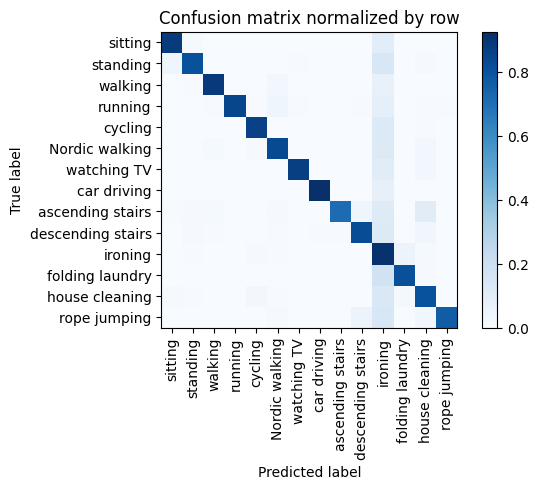

Training Epoch:  80%|████████  | 8/10 [02:25<00:35, 17.85s/it]

Overall accuracy: 0.844



seen: 100%|██████████| 122/122 [00:02<00:00, 50.22batch/s, loss=0.907]


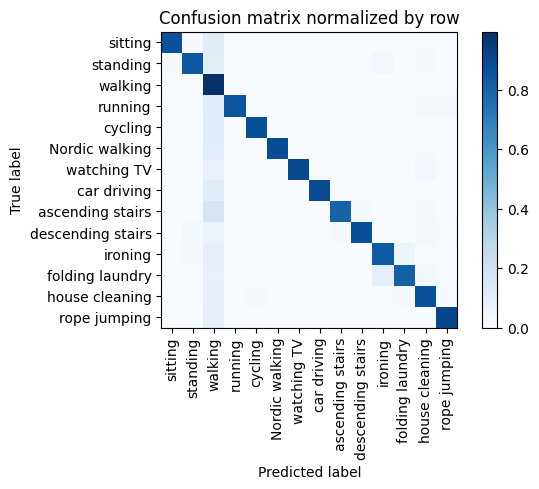

Training Epoch:  90%|█████████ | 9/10 [02:43<00:17, 17.87s/it]

Overall accuracy: 0.873



seen: 100%|██████████| 122/122 [00:02<00:00, 59.25batch/s, loss=0.613]


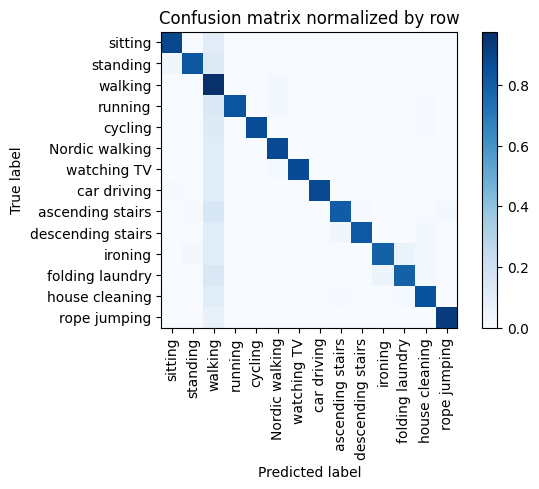

Overall accuracy: 0.859



unseen: 100%|██████████| 179/179 [00:02<00:00, 75.48batch/s, loss=5.99]


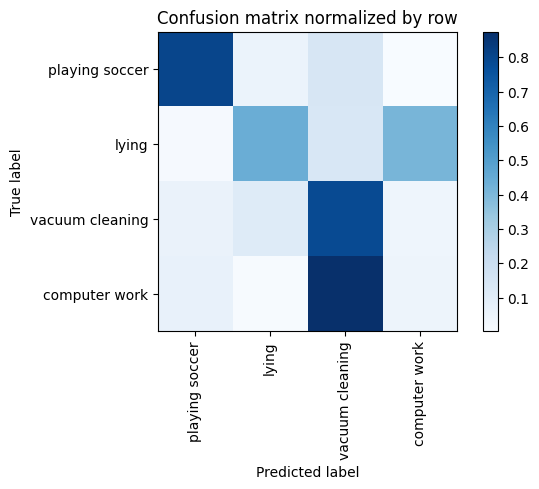

Overall accuracy: 0.378

                  precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

  computer work       0.146      0.047      0.071      0.432       2463|	 vacuum cleaning: 0.875,	playing soccer: 0.069,	
          lying       0.769      0.442      0.561      0.261       1488|	 computer work: 0.411,	vacuum cleaning: 0.137,	
vacuum cleaning       0.309      0.786      0.444      0.241       1372|	 lying: 0.112,	playing soccer: 0.060,	
 playing soccer       0.530      0.801      0.638      0.066        377|	 vacuum cleaning: 0.141,	lying: 0.056,	

----------------------------------------------------------------------------------------------------
    avg / total       0.373      0.378      0.326        1.0       5700|	      

{'total_accuracy': 0.3775438596491228, 'precision': 0.43856024496979024, 'recall': 0.51874964473474, 'f1': 0.4282904707206619}
================ Fold-3 ================
Unseen Classes : ['cycling', 'running', 'Nordic walking']


seen: 100%|██████████| 139/139 [00:02<00:00, 57.20batch/s, loss=0.977]


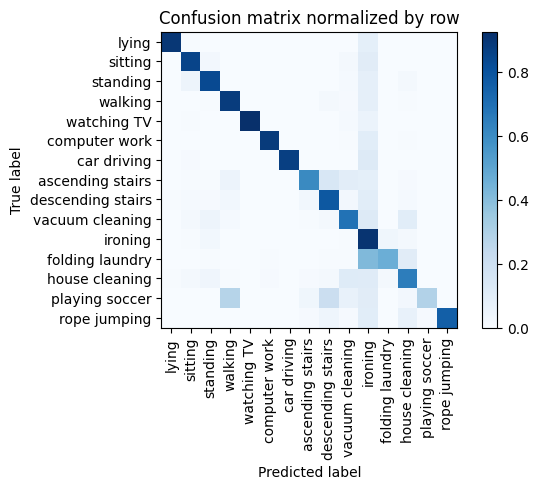

Training Epoch:  10%|█         | 1/10 [00:20<03:02, 20.29s/it]

Overall accuracy: 0.795



seen: 100%|██████████| 139/139 [00:02<00:00, 56.50batch/s, loss=0.698]


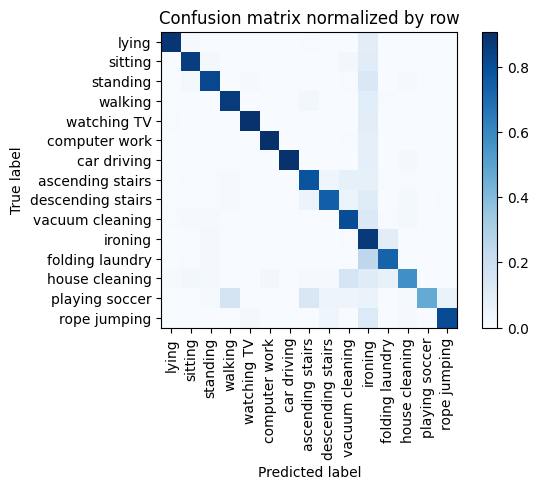

Training Epoch:  20%|██        | 2/10 [00:42<02:51, 21.43s/it]

Overall accuracy: 0.817



seen: 100%|██████████| 139/139 [00:02<00:00, 56.20batch/s, loss=0.49]


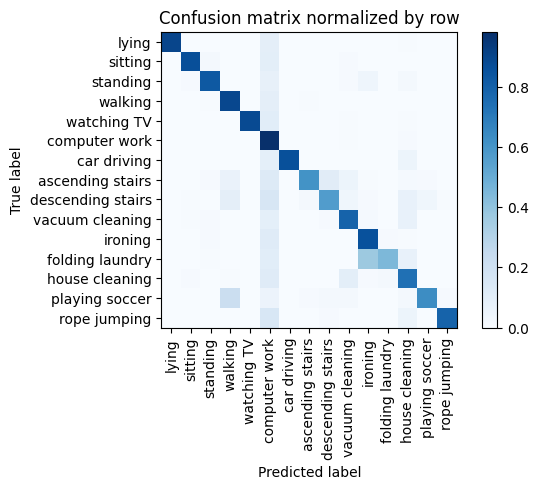

Training Epoch:  30%|███       | 3/10 [01:04<02:30, 21.51s/it]

Overall accuracy: 0.816



seen: 100%|██████████| 139/139 [00:02<00:00, 59.65batch/s, loss=0.446]


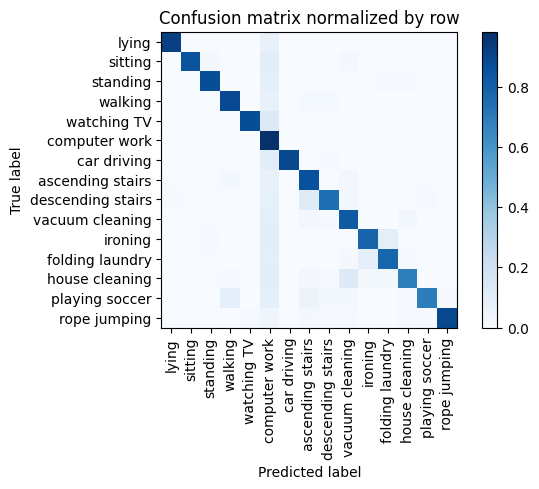

Training Epoch:  40%|████      | 4/10 [01:25<02:07, 21.33s/it]

Overall accuracy: 0.847



seen: 100%|██████████| 139/139 [00:02<00:00, 57.79batch/s, loss=0.219]


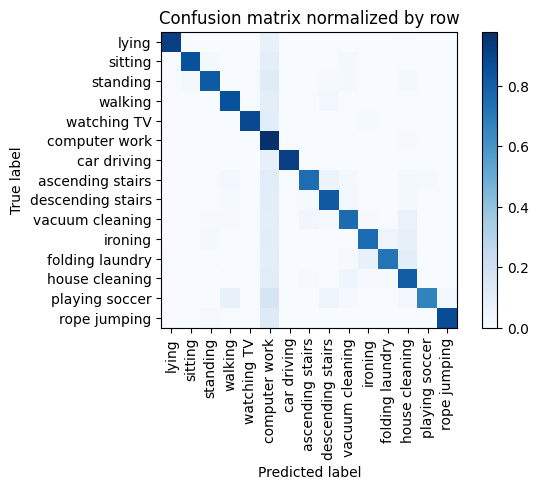

Training Epoch:  50%|█████     | 5/10 [01:44<01:43, 20.69s/it]

Overall accuracy: 0.838



seen: 100%|██████████| 139/139 [00:02<00:00, 62.98batch/s, loss=0.211]


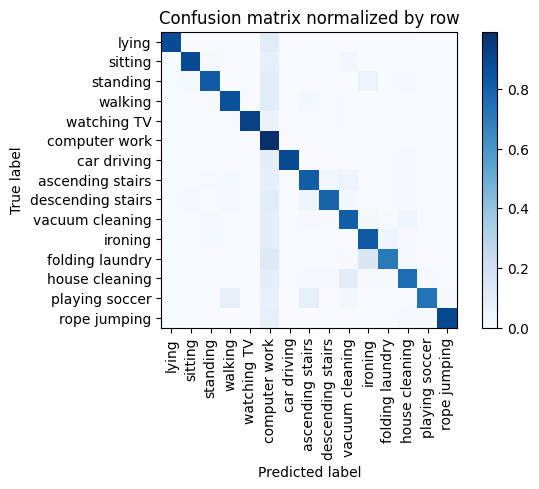

Training Epoch:  60%|██████    | 6/10 [02:03<01:19, 19.96s/it]

Overall accuracy: 0.854



seen: 100%|██████████| 139/139 [00:02<00:00, 63.67batch/s, loss=0.189]


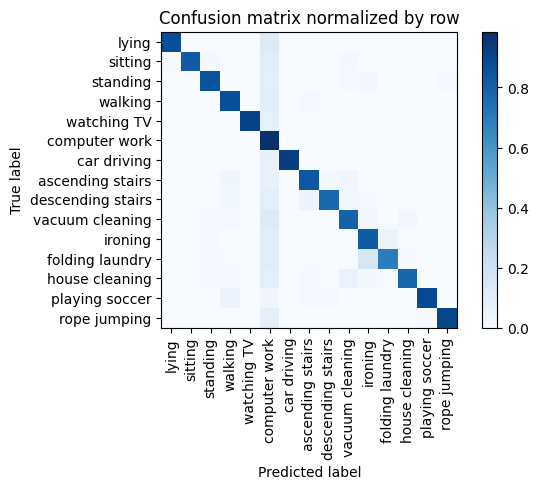

Training Epoch:  70%|███████   | 7/10 [02:22<00:58, 19.59s/it]

Overall accuracy: 0.853



seen: 100%|██████████| 139/139 [00:02<00:00, 61.73batch/s, loss=0.214]


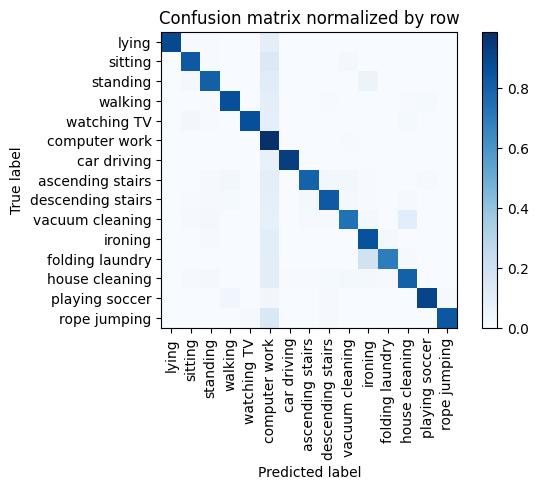

Training Epoch:  80%|████████  | 8/10 [02:40<00:38, 19.36s/it]

Overall accuracy: 0.852



seen: 100%|██████████| 139/139 [00:02<00:00, 59.14batch/s, loss=0.422]


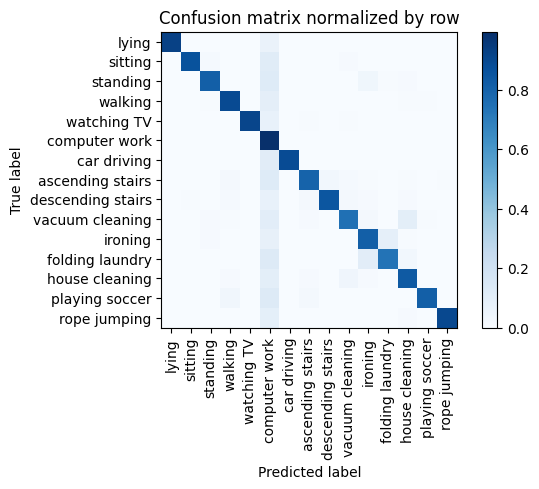

Training Epoch:  90%|█████████ | 9/10 [02:59<00:19, 19.16s/it]

Overall accuracy: 0.863



seen: 100%|██████████| 139/139 [00:02<00:00, 63.39batch/s, loss=0.201]


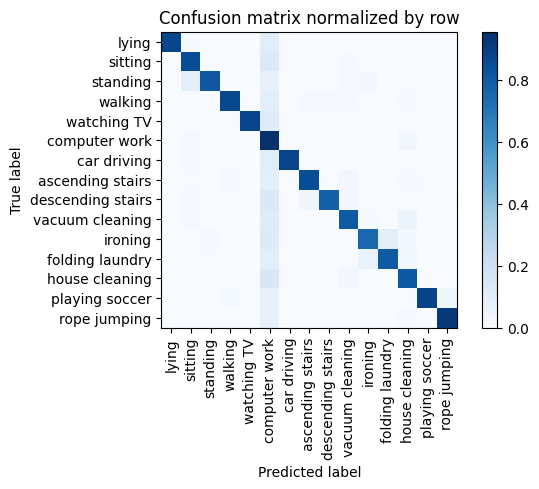

Overall accuracy: 0.846



unseen: 100%|██████████| 110/110 [00:01<00:00, 77.58batch/s, loss=4.77]


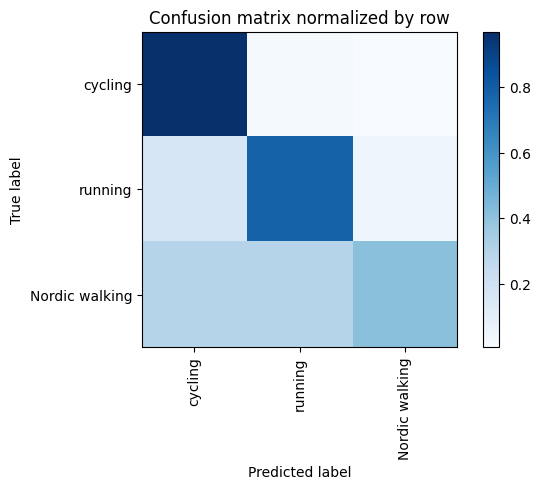

Overall accuracy: 0.692

                 precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

Nordic walking       0.923      0.410      0.568      0.422       1485|	 cycling: 0.296,	running: 0.294,	
       cycling       0.685      0.968      0.802      0.361       1270|	 running: 0.024,	Nordic walking: 0.009,	
       running       0.561      0.782      0.653      0.217        762|	 cycling: 0.165,	Nordic walking: 0.052,	

----------------------------------------------------------------------------------------------------
   avg / total       0.758      0.692      0.671        1.0       3517|	      

{'total_accuracy': 0.6920671026442992, 'precision': 0.7228219721798191, 'recall': 0.7199899255017366, 'f1': 0.6744007246375}
================ Fold-4 ================
Unseen Classes : ['ironing', 'car driving', 'folding laundry']


seen: 100%|██████████| 142/142 [00:02<00:00, 58.03batch/s, loss=0.494]


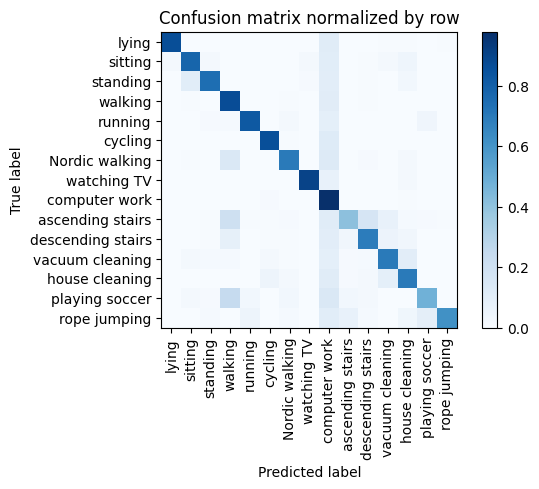

Training Epoch:  10%|█         | 1/10 [00:19<02:55, 19.50s/it]

Overall accuracy: 0.779



seen: 100%|██████████| 142/142 [00:02<00:00, 65.06batch/s, loss=0.369]


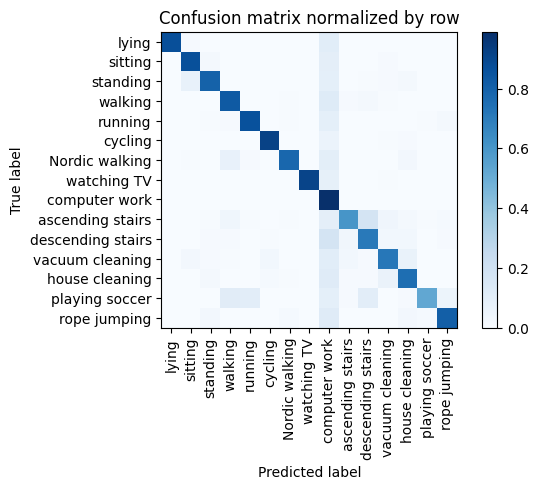

Training Epoch:  20%|██        | 2/10 [00:39<02:37, 19.69s/it]

Overall accuracy: 0.823



seen: 100%|██████████| 142/142 [00:02<00:00, 62.16batch/s, loss=0.326]


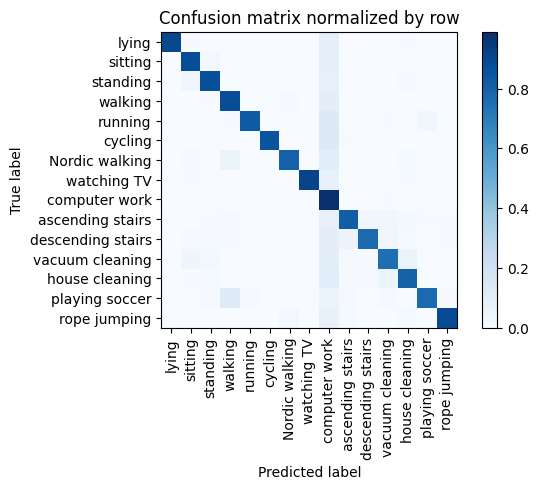

Training Epoch:  30%|███       | 3/10 [00:58<02:15, 19.40s/it]

Overall accuracy: 0.857



seen: 100%|██████████| 142/142 [00:02<00:00, 49.42batch/s, loss=0.319]


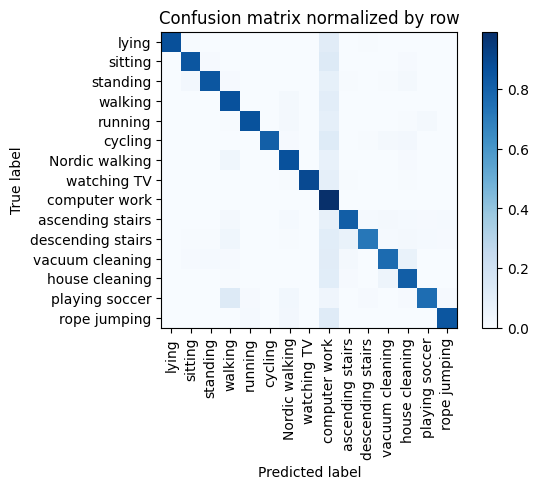

Training Epoch:  40%|████      | 4/10 [01:21<02:04, 20.73s/it]

Overall accuracy: 0.854



seen: 100%|██████████| 142/142 [00:03<00:00, 39.50batch/s, loss=0.186]


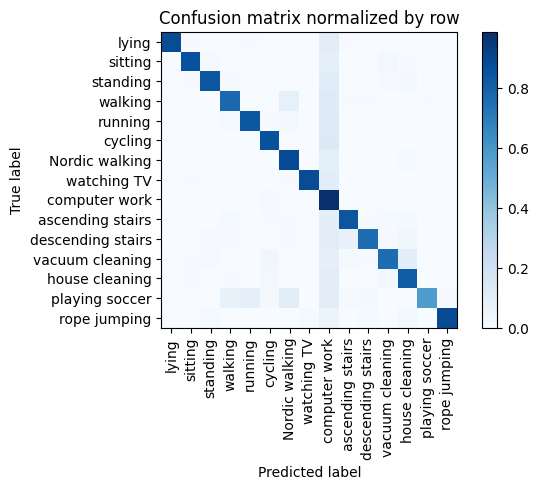

Training Epoch:  50%|█████     | 5/10 [01:45<01:50, 22.12s/it]

Overall accuracy: 0.847



seen: 100%|██████████| 142/142 [00:02<00:00, 57.29batch/s, loss=0.21]


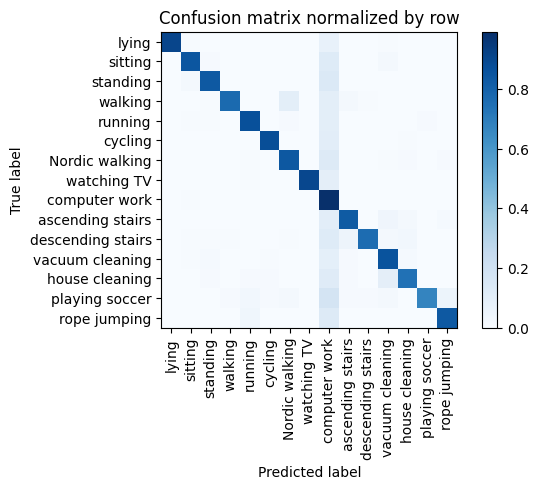

Training Epoch:  60%|██████    | 6/10 [02:06<01:26, 21.72s/it]

Overall accuracy: 0.850



seen: 100%|██████████| 142/142 [00:02<00:00, 57.32batch/s, loss=0.295]


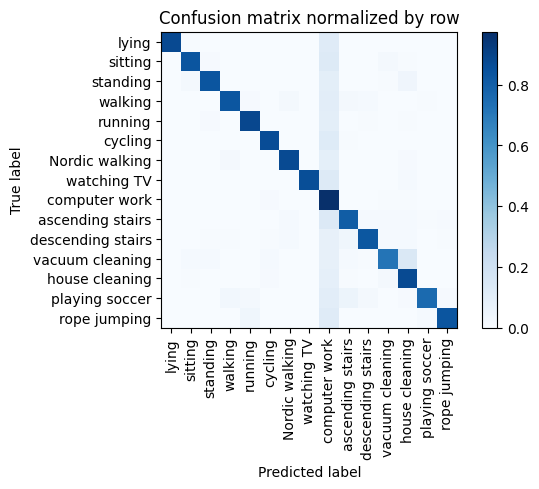

Training Epoch:  70%|███████   | 7/10 [02:27<01:04, 21.38s/it]

Overall accuracy: 0.856



seen: 100%|██████████| 142/142 [00:02<00:00, 61.40batch/s, loss=0.152]


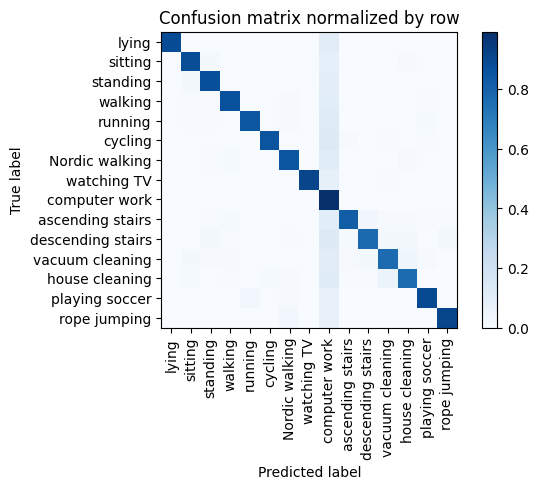

Training Epoch:  80%|████████  | 8/10 [02:48<00:42, 21.40s/it]

Overall accuracy: 0.863



seen: 100%|██████████| 142/142 [00:02<00:00, 60.90batch/s, loss=0.183]


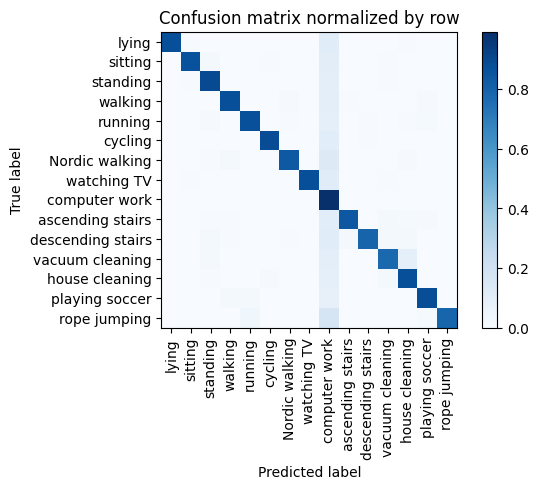

Training Epoch:  90%|█████████ | 9/10 [03:12<00:21, 21.97s/it]

Overall accuracy: 0.874



seen: 100%|██████████| 142/142 [00:02<00:00, 58.48batch/s, loss=0.428]


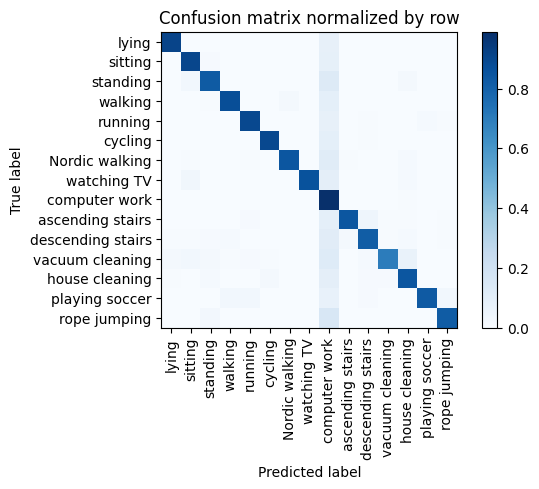

Overall accuracy: 0.869



unseen: 100%|██████████| 97/97 [00:01<00:00, 76.38batch/s, loss=5.33]


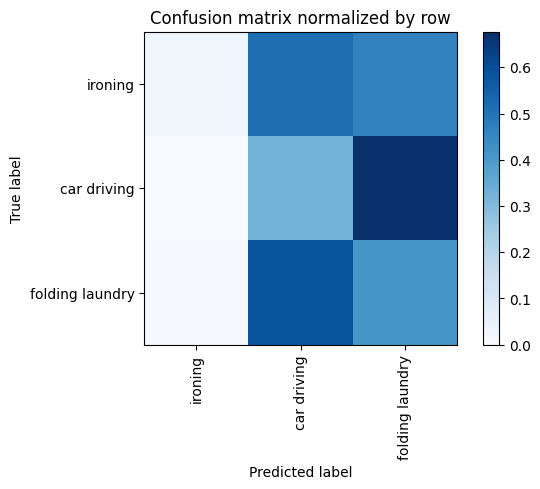

Overall accuracy: 0.163

                  precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

        ironing       0.902      0.024      0.048      0.609       1878|	 car driving: 0.513,	folding laundry: 0.462,	
folding laundry       0.216      0.408      0.282      0.253        780|	 car driving: 0.586,	ironing: 0.006,	
    car driving       0.089      0.323      0.139      0.138        427|	 folding laundry: 0.677,	ironing: 0.000,	

----------------------------------------------------------------------------------------------------
    avg / total       0.616      0.163      0.120        1.0       3085|	      

{'total_accuracy': 0.1627228525121556, 'precision': 0.40202409520067833, 'recall': 0.25179048736897164, 'f1': 0.15623527540391705}
============== Overall Unseen Classes Performance ==============


total_accuracy    0.457268
precision         0.517512
recall            0.480538
f1                0.415702
dtype: float64

In [18]:
from tkinter import N


fold_metric_scores = []
for i, cs in enumerate(fold_cls_ids):
    print("="*16, f'Fold-{i}', "="*16)
    print(f'Unseen Classes : {fold_classes[i]}')
    # separate seen/unseen and train/eval 
    data_dict = dataReader.generate(unseen_classes=cs, resampling=True, seen_ratio=config['seen_split'], unseen_ratio=config['unseen_split'], window_size=5.21, window_overlap=4.21, resample_freq=20)
    all_classes = dataReader.idToLabel
    seen_classes = data_dict['seen_classes']
    unseen_classes = data_dict['unseen_classes']
    # print("seen classes > ", seen_classes)
    # print("unseen classes > ", unseen_classes)
    train_n, seq_len, in_ft = data_dict['train']['X'].shape
    # build train_dt 
    # print(seen_classes)
    train_dt = PAMAP2Dataset(data=data_dict['train']['X'], actions=data_dict['train']['y'], attributes=attr_mat, action_feats=feat_mat, action_classes=seen_classes)
    train_dl = DataLoader(train_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
    # build seen eval_dt 
    eval_dt = PAMAP2Dataset(data=data_dict['eval-seen']['X'], actions=data_dict['eval-seen']['y'], attributes=attr_mat, action_feats=feat_mat, action_classes=seen_classes)
    eval_dl = DataLoader(eval_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
    # build unseen test_dt
    test_dt = PAMAP2Dataset(data=data_dict['test']['X'], actions=data_dict['test']['y'], attributes=attr_mat, action_feats=feat_mat, action_classes=unseen_classes)
    test_dl = DataLoader(test_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
    
    # build model
    model = Model12(in_ft=in_ft, d_model=config['d_model'], num_heads=config['num_heads'], dim_feedforward=config['dim_feedforward'], n_classes=len(seen_classes),
                num_layers=config['num_layers'], ft_size=feat_size, max_len=seq_len, pos_encoding=config['pos_encoding'], activation=config['activation'], norm=config['norm'])
    # model = Model1(feat_dim=in_ft, max_len=seq_len, d_model=config['d_model'], n_heads=config['num_heads'], num_layers=2, dim_feedforward=128, ft_size=feat_size)
    model.to(device)
    # define run parameters 
    optimizer = Adam(model.parameters(), lr=config['lr'])
    loss_module = {'class': nn.CrossEntropyLoss(), 'feature': AttributeLoss()}
    best_acc = 0.0
    # train the model 
    for epoch in tqdm(range(config['n_epochs']), desc='Training Epoch', leave=False):
        train_metrics = train_step1(model, train_dl, optimizer, loss_module, device, class_names=[all_classes[i] for i in seen_classes], phase='train', loss_alpha=0.6)
        eval_metrics = eval_step1(model, eval_dl, loss_module, device, class_names=[all_classes[i] for i in seen_classes],  target_feat_met=eval_dt.target_feat, phase='seen', print_report=False, loss_alpha=0.6)
        # print(f"EPOCH [{epoch}] TRAINING : {train_metrics}")
        # print(f"EPOCH [{epoch}] EVAL : {eval_metrics}")
        if eval_metrics['total_accuracy'] > best_acc:
            best_model = deepcopy(model.state_dict())
    
    if best_acc == 0.0:
        best_model = deepcopy(model.state_dict())
    
    # replace by best model 
    model.load_state_dict(best_model)

    # run evaluation on unseen classes
    test_metrics = eval_step1(model, test_dl, loss_module, device, class_names=[all_classes[i] for i in unseen_classes],  target_feat_met=test_dt.target_feat, phase='unseen', loss_alpha=0.6)
    fold_metric_scores.append(test_metrics)
    print(test_metrics)
    print("="*40)
print("="*14, "Overall Unseen Classes Performance", "="*14)
seen_score_df = pd.DataFrame.from_records(fold_metric_scores)
seen_score_df.mean()
    